# Elementy Inteligencji Obliczeniowej - Sieci Neuronowe


---

**Prowadzący:** Jakub Bednarek<br>
**Kontakt:** jakub.bednarek@put.poznan.pl<br>
**Materiały:** [Strona WWW](http://jakub.bednarek.pracownik.put.poznan.pl)

---

## Uwaga

* **Aby wykonać polecenia należy najpierw przejść do trybu 'playground'. File -> Open in Playground Mode**
* Nowe funkcje Colab pozwalają na autouzupełnianie oraz czytanie dokumentacji

## Cel ćwiczeń:
- zapoznanie się z Keras subclassing API
- stworzenie własnych modeli i warstw z wykorzystaniem Keras subclassing API
- wykorzystanie podstawowych mechanizmów regularyzacji: Dropout i Batch normalization

In [16]:
%tensorflow_version 2.x

import tensorflow as tf
import numpy as np

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [17]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Layer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy, mse
from tensorflow.keras.optimizers import Adadelta, RMSprop
from tensorflow.python.keras import backend as K


In [22]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()


x_train = x_train[:, :, :, np.newaxis].astype('float32')
x_test = x_test[:, :, :, np.newaxis].astype('float32')
x_train /= 255
x_test /= 255

# x_train = x_train.reshape(60000, 784)
# x_test = x_test.reshape(10000, 784)

x_train_reshaped = x_train.reshape(60000, 784)
x_test_reshaped = x_test.reshape(10000, 784)

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

## Tworzenie własnych modeli i warstw 
https://www.tensorflow.org/tutorials/customization/custom_layers

https://www.tensorflow.org/guide/keras/custom_layers_and_models

Przykładowy model z warstwami gęstymi dla danych MNIST:

In [19]:
class DenseModel(Model):

  def __init__(self, num_classes=10):
    super(DenseModel, self).__init__(name='my_model')
    self.num_classes = num_classes
    # Define your layers here.
    self.dense_1 = Dense(512, input_shape=(784,), activation='relu')
    self.dense_2 = Dense(512, activation='relu')
    self.dense_3 = Dense(num_classes, activation='softmax')

  def call(self, inputs):
    # Define your forward pass here,
    # using layers you previously defined (in `__init__`).
    x = self.dense_1(inputs)
    x = self.dense_2(x)
    return self.dense_3(x)

model = DenseModel(num_classes=10)

In [20]:
model.compile(optimizer=RMSprop(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=32, epochs=3)

Epoch 1/3
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1911 - accuracy: 0.9426
Epoch 2/3
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1029 - accuracy: 0.9734
Epoch 3/3
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0857 - accuracy: 0.9786


Przykład własnej warstwy. Warstwa to po prostu funkcjonalny moduł do wielokrotnego używania, podczas gdy model to gotowe rozwiązanie dla danego problemu uczenia maszynowego (tzn. w Kerasie zazwyczaj kompletna sieć neuronowa), które udostępnia dodatkowo takie metody jak `fit`, `evaluate` i `predict`. Oczywiście można też budować modele/warstwy korzystające z innych modeli/warstw, API obu tych klas jest bardzo podobne.

W poniższym kodzie, metoda `build` w `CustomLayer` jest wołana raz przed pierwszym wywołaniem `call` (zaimplementowane jest to w `__call__()`), co pozwala nam uzależnić liczbę wag warstwy od wymiaru wyjść z warstwy poprzedniej. Jeżeli odgórnie wiemy, ile wag ma mieć warstwa, to równie dobrze możemy je zainicjować w `__init__` tak jak wcześniej.

In [21]:
class CustomLayer(Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(CustomLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel',
                                      shape=(int(input_shape[1]), self.output_dim),
                                      initializer='uniform',
                                      trainable=True)

    def call(self, inputs):
        return tf.matmul(inputs, self.kernel)


class CustomModel(Model):

    def __init__(self, num_classes=10):
        super(CustomModel, self).__init__(name='custom_model')
        self.num_classes = num_classes
        # Define your layers here.
        self.dense_1 = CustomLayer(output_dim=512, input_shape=(784,))
        self.dense_2 = CustomLayer(output_dim=512, input_shape=(512,))
        self.dense_3 = CustomLayer(output_dim=num_classes, input_shape=(512,))

    def call(self, inputs):
        # Define your forward pass here,
        # using layers you previously defined (in `__init__`).
        x = self.dense_1(inputs)
        x = K.relu(x)
        x = self.dense_2(x)
        x = K.relu(x)
        x = self.dense_3(x)
        x = K.sigmoid(x)
        return x

model = CustomModel(num_classes=10)

model.compile(optimizer=RMSprop(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model.fit(x_train, y_train, batch_size=128, epochs=3)

Epoch 1/3
469/469 [==============================] - 2s 3ms/step - loss: 0.2842 - accuracy: 0.9141
Epoch 2/3
469/469 [==============================] - 2s 4ms/step - loss: 0.0961 - accuracy: 0.9711
Epoch 3/3
469/469 [==============================] - 2s 3ms/step - loss: 0.0644 - accuracy: 0.9802


### Zadanie 1
Na podstawie powyższego przykładu stwórz własny model kolejno składający się z:
- warstwy konwolucyjnej (Conv2D): 32 filtry 3x3,
- konwolucyjnej: 64 filtry 3x3,
- warstwy MaxPooling (MaxPooling2D): 2x2
- warstwy ukrytej gęstej (Dense): 128 neuronów,
- warstwy wyjściowej.

Ważne:
- w każdej warstwie poza warstwą wyjściową funkcją aktywacji powinno być relu,
- funkcja aktywacji dla warstwy wyjściowej to softmax,
- między częścią konwolucyjną a gęstą trzeba spłaszczyć tensor przy pomocy warstwy `Flatten`,
- w przykładzie jest wykorzystywana sieć gęsta (dane są spłaszczone), sieci z warstwami konwolucyjnymi muszą otrzymać tensor 4-wymiarowy, zakomentuj linie "spłaszczające" podczas wczytywania danych.
```
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
```

In [23]:
class MyModel(Model):

    def __init__(self, num_classes=10):
        super(MyModel, self).__init__(name='my_model')
        self.num_classes = num_classes
        self.conv1 = Conv2D(32, (3, 3), activation = 'relu')
        self.conv2 = Conv2D(64, (3, 3), activation = 'relu')
        self.maxpooling = MaxPooling2D((2, 2))
        self.flatten = Flatten()
        self.dense = Dense(128, activation='relu')
        self.dense2 = Dense(num_classes, activation = 'softmax')

    def call(self, inputs):
        # Define your forward pass here,
        # using layers you previously defined (in `__init__`).
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.maxpooling(x)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.dense2(x)
        return x

model = MyModel(num_classes=10)
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])
model1_result = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data = (x_test, y_test))

Epoch 1/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1067 - accuracy: 0.9676 - val_loss: 0.0381 - val_accuracy: 0.9875
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0401 - accuracy: 0.9875 - val_loss: 0.0378 - val_accuracy: 0.9871
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0283 - accuracy: 0.9918 - val_loss: 0.0408 - val_accuracy: 0.9878
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0225 - accuracy: 0.9932 - val_loss: 0.0389 - val_accuracy: 0.9883
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0190 - accuracy: 0.9944 - val_loss: 0.0442 - val_accuracy: 0.9900
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0162 - accuracy: 0.9957 - val_loss: 0.0452 - val_accuracy: 0.9902
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0136 - accuracy: 0.9967 - val_loss: 0.0527 - val_accuracy:

### Zadanie 2 
Na podstawie powyższego przykładu stwórz model bloku ResNet:
- w warstwach konwolucyjnych wykorzystaj padding='same', aby rozmiary tensorów się nie zmieniały,
- tego modelu nie trzeba budować i uczyć, zostanie on wykorzystany w kolejnym zadaniu.

![resnet](https://miro.medium.com/max/1000/1*6HDuqhUzP92iXhHoS0Wl3w.png)

In [24]:
class ResNetModel(Model):

    def __init__(self):
        super(ResNetModel, self).__init__(name='resnet_model')
        self.conv1 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')
        self.conv2 = Conv2D(64, (3, 3), padding = 'same')

    def call(self, inputs):
        # Define your forward pass here,
        # using layers you previously defined (in `__init__`).
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = x + inputs
        x = K.relu(x)
        return x

### Zadanie 3
Zmodyfikuj model z zadania 1, zamieniając warstwy konwolucyjne na dwa modele bloku ResNet z zadania 2.

In [25]:
class MyModel2(Model):

    def __init__(self, num_classes=10):
        super(MyModel2, self).__init__(name='my_model2')
        self.num_classes = num_classes
        self.resnet1 = ResNetModel()
        self.resnet2 = ResNetModel()
        self.maxpooling = MaxPooling2D((2, 2))
        self.flatten = Flatten()
        self.dense = Dense(128, activation='relu')
        self.dense2 = Dense(num_classes, activation = 'softmax')

    def call(self, inputs):
        # Define your forward pass here,
        # using layers you previously defined (in `__init__`).
        x = self.resnet1(inputs)
        x = self.resnet2(x)
        x = self.maxpooling(x)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.dense2(x)
        return x

model = MyModel2(num_classes=10)
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data = (x_test, y_test))

Epoch 1/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.1168 - accuracy: 0.9667 - val_loss: 0.0419 - val_accuracy: 0.9861
Epoch 2/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0461 - accuracy: 0.9865 - val_loss: 0.0458 - val_accuracy: 0.9851
Epoch 3/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0374 - accuracy: 0.9898 - val_loss: 0.0428 - val_accuracy: 0.9879
Epoch 4/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0331 - accuracy: 0.9912 - val_loss: 0.0451 - val_accuracy: 0.9871
Epoch 5/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0286 - accuracy: 0.9928 - val_loss: 0.0565 - val_accuracy: 0.9864
Epoch 6/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0234 - accuracy: 0.9938 - val_loss: 0.0551 - val_accuracy: 0.9870
Epoch 7/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0215 - accuracy: 0.9944 - val_loss: 0.0761 - val_a

### Zadanie 4
Wykorzystując Keras Subclassing API, napisz Autoenkoder dla zbioru danych MNIST.
- stwórz osobny model Enkodera,
- stwórz osobny model Dekodera,
- połącz oba modele celem zbudowania Autoenkodera,
- można korzystać z warstw gęstych, nie trzeba korzystać z konwolucji,
- poprzednie zadania były przykładem klasyfikacji, w których wykorzystywana była funkcja błędu categorical_crossentropy (która jest stosowana dla wektorów reprezentujących rozkład prawdopodobieństwa), w przypadku Autoenkoderów model rekonstruuje dane wejściowe, więc najłatwiej wykorzystać mean square error (mse),
- w związku z powyższym również wyjście sieci się różni, nie klasyfikujemy (y_train) tylko rekonstruujemy (x_train)

https://blog.keras.io/building-autoencoders-in-keras.html

In [11]:
class Encoder(Model):
    def __init__(self):
        super(Encoder, self).__init__(name='encoder')
        self.dense1 = Dense(128, activation='relu')
        self.dense2 = Dense(64, activation='relu')
        self.dense3 = Dense(32, activation='relu')

    def call(self, inputs):
        # Define your forward pass here,
        # using layers you previously defined (in `__init__`).
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        return x

class Decoder(Model):
    def __init__(self):
        super(Decoder, self).__init__(name='decoder')
        self.dense1 = Dense(64, activation='relu')
        self.dense2 = Dense(128, activation='relu')
        self.dense3 = Dense(784, activation='sigmoid')

    def call(self, inputs):
        # Define your forward pass here,
        # using layers you previously defined (in `__init__`).
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        return x

class AutoEncoder(Model):
    def __init__(self):
        super(AutoEncoder, self).__init__(name='autoencoder')
        self.encoder = Encoder()
        self.decoder = Decoder()

    def call(self, inputs):
        # Define your forward pass here,
        # using layers you previously defined (in `__init__`).
        x = self.encoder(inputs)
        x = self.decoder(x)
        return x

model = AutoEncoder()
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.fit(x_train_reshaped, x_train_reshaped, batch_size=256, epochs=10, shuffle = True, validation_data = (x_test_reshaped, x_test_reshaped))

Epoch 1/10
235/235 [==============================] - 2s 6ms/step - loss: 0.0647 - accuracy: 0.0071 - val_loss: 0.0372 - val_accuracy: 0.0078
Epoch 2/10
235/235 [==============================] - 1s 5ms/step - loss: 0.0308 - accuracy: 0.0115 - val_loss: 0.0256 - val_accuracy: 0.0130
Epoch 3/10
235/235 [==============================] - 1s 5ms/step - loss: 0.0235 - accuracy: 0.0129 - val_loss: 0.0209 - val_accuracy: 0.0133
Epoch 4/10
235/235 [==============================] - 1s 5ms/step - loss: 0.0202 - accuracy: 0.0125 - val_loss: 0.0186 - val_accuracy: 0.0124
Epoch 5/10
235/235 [==============================] - 1s 5ms/step - loss: 0.0183 - accuracy: 0.0121 - val_loss: 0.0172 - val_accuracy: 0.0114
Epoch 6/10
235/235 [==============================] - 1s 5ms/step - loss: 0.0170 - accuracy: 0.0107 - val_loss: 0.0160 - val_accuracy: 0.0096
Epoch 7/10
235/235 [==============================] - 1s 5ms/step - loss: 0.0160 - accuracy: 0.0109 - val_loss: 0.0152 - val_accuracy: 0.0097
Epoch 

In [12]:
from tensorflow.keras.layers import UpSampling2D

class EncoderConv(Model):
    def __init__(self):
        super(Encoder, self).__init__(name='encoder')
        self.conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')
        self.pooling1 = MaxPooling2D((2,2), padding='same')
        self.conv2 = Conv2D(8, (3, 3), activation='relu', padding='same')
        self.pooling2 = MaxPooling2D((2,2), padding='same')
        self.conv3 = Conv2D(8, (3, 3), activation='relu', padding='same')
        self.pooling3 = MaxPooling2D((2,2), padding='same')

    def call(self, inputs):
        # Define your forward pass here,
        # using layers you previously defined (in `__init__`).
        x = self.conv1(inputs)
        x = self.pooling1(x)
        x = self.conv2(x)
        x = self.pooling2(x)
        x = self.conv3(x)
        x = self.pooling3(x)
        return x

class DecoderConv(Model):
    def __init__(self):
        super(Decoder, self).__init__(name='decoder')
        self.conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')
        self.sampling1 = UpSampling2D((2,2))
        self.conv2 = Conv2D(8, (3, 3), activation='relu', padding='same')
        self.sampling2 = UpSampling2D((2,2))
        self.conv3 = Conv2D(16, (3, 3), activation='relu')
        self.sampling3 = UpSampling2D((2,2))
        self.conv4 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')

    def call(self, inputs):
        # Define your forward pass here,
        # using layers you previously defined (in `__init__`).
        x = self.conv1(inputs)
        x = self.sampling1(x)
        x = self.conv2(x)
        x = self.sampling2(x)
        x = self.conv3(x)
        x = self.sampling3(x)
        x = self.conv4(x)
        return x

class AutoEncoderConv(Model):
    def __init__(self):
        super(AutoEncoder, self).__init__(name='autoencoder')
        self.encoder = EncoderConv()
        self.decoder = DecoderConv()

    def call(self, inputs):
        # Define your forward pass here,
        # using layers you previously defined (in `__init__`).
        x = self.encoder(inputs)
        x = self.decoder(x)
        return x

model = AutoEncoder()
model.compile(optimizer='adadelta', loss='mse', metrics=['accuracy'])
model.fit(x_train, x_train, batch_size=32, epochs=10, shuffle = True, validation_data = (x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 48s 25ms/step - loss: 0.2313 - accuracy: 8.6943e-04 - val_loss: 0.2313 - val_accuracy: 0.0000e+00
Epoch 2/10
1875/1875 [==============================] - 46s 24ms/step - loss: 0.2312 - accuracy: 0.0000e+00 - val_loss: 0.2312 - val_accuracy: 0.0000e+00
Epoch 3/10
1875/1875 [==============================] - 46s 24ms/step - loss: 0.2311 - accuracy: 0.0000e+00 - val_loss: 0.2311 - val_accuracy: 0.0000e+00
Epoch 4/10
1875/1875 [==============================] - 46s 24ms/step - loss: 0.2310 - accuracy: 0.0000e+00 - val_loss: 0.2310 - val_accuracy: 0.0000e+00
Epoch 5/10
1875/1875 [==============================] - 46s 25ms/step - loss: 0.2309 - accuracy: 0.0000e+00 - val_loss: 0.2309 - val_accuracy: 0.0000e+00
Epoch 6/10
1875/1875 [==============================] - 46s 24ms/step - loss: 0.2308 - accuracy: 0.0000e+00 - val_loss: 0.2308 - val_accuracy: 0.0000e+00
Epoch 7/10
1875/1875 [==============================] - 46s 25ms/step - loss

## Regularyzacja
### Zadanie 5
Rozszerz model stworzony w zadaniu 1 o dwie warstwy Dropout (Dropout - https://keras.io/api/layers/regularization_layers/dropout/):
- jedna po warstwie MaxPooling (wartość współczynnika odrzucenia 0.25)
- druga po gęstej warstwie ukrytej (Dense), wartość współczynnika odrzucenia 0.5.

  





In [26]:
class MyModel3(Model):

    def __init__(self, num_classes=10):
        super(MyModel3, self).__init__(name='my_model3')
        self.num_classes = num_classes
        self.conv1 = Conv2D(32, (3, 3), activation = 'relu')
        self.conv2 = Conv2D(64, (3, 3), activation = 'relu')
        self.maxpooling = MaxPooling2D((2, 2))
        self.dropout1 = Dropout(0.25)
        self.flatten = Flatten()
        self.dense = Dense(128, activation='relu')
        self.dropout2 = Dropout(0.5)
        self.dense2 = Dense(num_classes, activation = 'softmax')

    def call(self, inputs):
        # Define your forward pass here,
        # using layers you previously defined (in `__init__`).
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.maxpooling(x)
        x = self.dropout1(x)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.dropout2(x)
        x = self.dense2(x)
        return x

model = MyModel3(num_classes=10)
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])
model5_result = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data = (x_test, y_test))

Epoch 1/10
1875/1875 [==============================] - 11s 5ms/step - loss: 0.1738 - accuracy: 0.9478 - val_loss: 0.0497 - val_accuracy: 0.9842
Epoch 2/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0873 - accuracy: 0.9750 - val_loss: 0.0462 - val_accuracy: 0.9853
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0811 - accuracy: 0.9775 - val_loss: 0.0476 - val_accuracy: 0.9852
Epoch 4/10
1875/1875 [==============================] - 8s 5ms/step - loss: 0.0828 - accuracy: 0.9773 - val_loss: 0.0565 - val_accuracy: 0.9839
Epoch 5/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0862 - accuracy: 0.9762 - val_loss: 0.0512 - val_accuracy: 0.9851
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0882 - accuracy: 0.9759 - val_loss: 0.0529 - val_accuracy: 0.9855
Epoch 7/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0928 - accuracy: 0.9746 - val_loss: 0.0580 - val_accur

### Zadanie 6
Rozszerz model stworzony w zadaniu 1 o dwie warstwy Batch normalization (BatchNormalization - https://keras.io/layers/normalization/) po warstwach konwolucyjnych.

In [27]:
class MyModel4(Model):

    def __init__(self, num_classes=10):
        super(MyModel4, self).__init__(name='my_model4')
        self.num_classes = num_classes
        self.conv1 = Conv2D(32, (3, 3), activation = 'relu')
        self.batch1 = BatchNormalization()
        self.conv2 = Conv2D(64, (3, 3), activation = 'relu')
        self.batch2 = BatchNormalization()
        self.maxpooling = MaxPooling2D((2, 2))
        self.flatten = Flatten()
        self.dense = Dense(128, activation='relu')
        self.dense2 = Dense(num_classes, activation = 'softmax')

    def call(self, inputs):
        # Define your forward pass here,
        # using layers you previously defined (in `__init__`).
        x = self.conv1(inputs)
        x = self.batch1(x)
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.maxpooling(x)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.dense2(x)
        return x

model = MyModel4(num_classes=10)
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])
model6_result = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data = (x_test, y_test))

Epoch 1/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2136 - accuracy: 0.9572 - val_loss: 0.0851 - val_accuracy: 0.9813
Epoch 2/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0858 - accuracy: 0.9836 - val_loss: 0.0905 - val_accuracy: 0.9827
Epoch 3/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0534 - accuracy: 0.9894 - val_loss: 0.0693 - val_accuracy: 0.9885
Epoch 4/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0358 - accuracy: 0.9926 - val_loss: 0.0664 - val_accuracy: 0.9876
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0247 - accuracy: 0.9947 - val_loss: 0.0907 - val_accuracy: 0.9865
Epoch 6/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0224 - accuracy: 0.9949 - val_loss: 0.1014 - val_accuracy: 0.9845
Epoch 7/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0169 - accuracy: 0.9965 - val_loss: 0.1043 - val_acc

### Zadanie 7
Rozszerz model stworzony w zadaniu 1 o warstwy z zadań 5 i 6.

In [28]:
class MyModel5(Model):

    def __init__(self, num_classes=10):
        super(MyModel5, self).__init__(name='my_model5')
        self.num_classes = num_classes
        self.conv1 = Conv2D(32, (3, 3), activation = 'relu')
        self.batch1 = BatchNormalization()
        self.conv2 = Conv2D(64, (3, 3), activation = 'relu')
        self.batch2 = BatchNormalization()
        self.maxpooling = MaxPooling2D((2, 2))
        self.dropout1 = Dropout(0.25)
        self.flatten = Flatten()
        self.dense = Dense(128, activation='relu')
        self.dropout2 = Dropout(0.5)
        self.dense2 = Dense(num_classes, activation = 'softmax')

    def call(self, inputs):
        # Define your forward pass here,
        # using layers you previously defined (in `__init__`).
        x = self.conv1(inputs)
        x = self.batch1(x)
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.maxpooling(x)
        x = self.dropout1(x)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.dropout2(x)
        x = self.dense2(x)
        return x

model = MyModel5(num_classes=10)
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])
model7_result = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data = (x_test, y_test))

Epoch 1/10
1875/1875 [==============================] - 11s 5ms/step - loss: 0.4166 - accuracy: 0.9101 - val_loss: 0.1629 - val_accuracy: 0.9693
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2149 - accuracy: 0.9566 - val_loss: 0.0783 - val_accuracy: 0.9813
Epoch 3/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1884 - accuracy: 0.9630 - val_loss: 0.0936 - val_accuracy: 0.9826
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1522 - accuracy: 0.9686 - val_loss: 0.0587 - val_accuracy: 0.9853
Epoch 5/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1298 - accuracy: 0.9715 - val_loss: 0.0539 - val_accuracy: 0.9862
Epoch 6/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.1218 - accuracy: 0.9724 - val_loss: 0.0472 - val_accuracy: 0.9873
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1100 - accuracy: 0.9742 - val_loss: 0.0567 - val_accu

### Zadanie 8 
Porównaj modele stworzone w zadaniach 1, 5, 6, 7 na zbiorze danych MNIST. Stwórz wykresy z przebiegiem błędu funkcji celu i trafności klasyfikacji dla zbioru treningowego i walidacyjnego.
Cztery wykresy:
- błąd funkcji celu dla zbioru treningowego,
- błąd funkcji celu dla zbioru walidacyjnego,
- trafność klasyfikacji dla zbioru treningowego,
- trafność klasyfikacji dla zbioru walidacyjnego

Na każdym wykresie powinny być 4 przebiegi dla modeli z wszystkich zadań (1, 5, 6, 7), tak by łatwo można je było ze sobą wizualnie porównać.


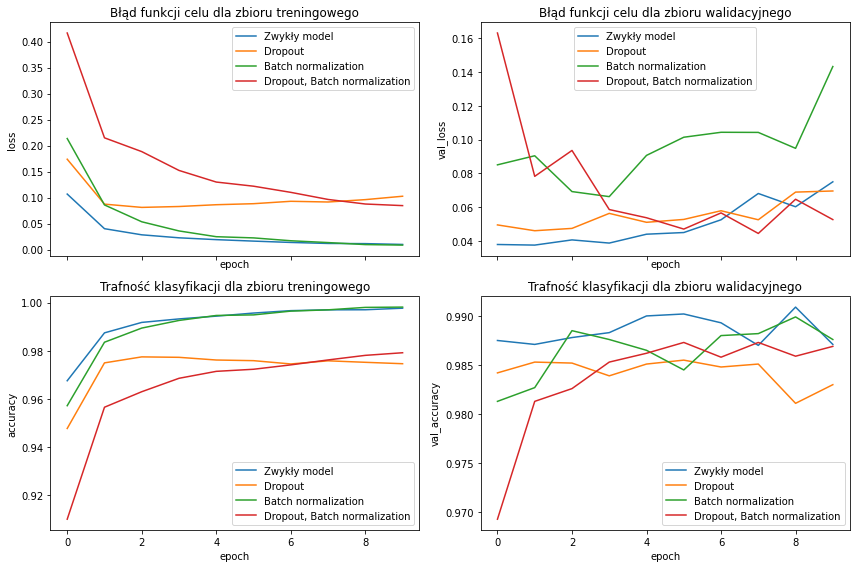

In [33]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

axs[0, 0].plot(model1_result.history['loss'], label='Model 1')
axs[0, 0].plot(model5_result.history['loss'], label='Model 5')
axs[0, 0].plot(model6_result.history['loss'], label='Model 6')
axs[0, 0].plot(model7_result.history['loss'], label='Model 7')
axs[0, 0].set_title("Błąd funkcji celu dla zbioru treningowego")
axs[0, 0].set_ylabel('loss')
axs[0, 0].set_xlabel('epoch')
axs[0, 0].legend(['Zwykły model', 'Dropout', 'Batch normalization', 'Dropout, Batch normalization'])

axs[0, 1].plot(model1_result.history['val_loss'], label='Model 1')
axs[0, 1].plot(model5_result.history['val_loss'], label='Model 5')
axs[0, 1].plot(model6_result.history['val_loss'], label='Model 6')
axs[0, 1].plot(model7_result.history['val_loss'], label='Model 7')
axs[0, 1].set_title("Błąd funkcji celu dla zbioru walidacyjnego")
axs[0, 1].set_ylabel('val_loss')
axs[0, 1].set_xlabel('epoch')
axs[0, 1].legend(['Zwykły model', 'Dropout', 'Batch normalization', 'Dropout, Batch normalization'])

axs[1, 0].plot(model1_result.history['accuracy'], label='Model 1')
axs[1, 0].plot(model5_result.history['accuracy'], label='Model 5')
axs[1, 0].plot(model6_result.history['accuracy'], label='Model 6')
axs[1, 0].plot(model7_result.history['accuracy'], label='Model 7')
axs[1, 0].set_title("Trafność klasyfikacji dla zbioru treningowego")
axs[1, 0].set_ylabel('accuracy')
axs[1, 0].set_xlabel('epoch')
axs[1, 0].legend(['Zwykły model', 'Dropout', 'Batch normalization', 'Dropout, Batch normalization'])

axs[1, 1].plot(model1_result.history['val_accuracy'], label='Model 1')
axs[1, 1].plot(model5_result.history['val_accuracy'], label='Model 5')
axs[1, 1].plot(model6_result.history['val_accuracy'], label='Model 6')
axs[1, 1].plot(model7_result.history['val_accuracy'], label='Model 7')
axs[1, 1].set_title("Trafność klasyfikacji dla zbioru walidacyjnego")
axs[1, 1].set_ylabel('val_accuracy')
axs[1, 1].set_xlabel('epoch')
axs[1, 1].legend(['Zwykły model', 'Dropout', 'Batch normalization', 'Dropout, Batch normalization'])

fig.tight_layout()